# HEST 多切片训练/预测/评估（INT25-INT28）

本 Notebook 以 INT25-INT28 为例，做完整的训练、预测和评估流程。
建议按**切片级别**划分训练/验证/测试，避免信息泄露。

缩写说明：
- ST = Spatial Transcriptomics（空间转录组）
- WSI = Whole Slide Image（全切片图像）
- MIL = Multiple Instance Learning（多实例学习）
- NB = Negative Binomial（负二项分布）
- ckpt = checkpoint（权重文件）


In [1]:
from pathlib import Path
import os
import sys

import logging
import warnings

# 1) 只屏蔽 CellFM 这块的日志警告
# logging.getLogger("st_pipeline.model.cellfm_wrapper").setLevel(logging.ERROR)

# 2) 如果还嫌多，再屏蔽所有 Python 警告（慎用）
warnings.filterwarnings("ignore")


# ====== 关键路径（请按你的机器修改）======
ROOT = Path(os.environ.get('MORPHO_VC_ROOT', '../')).expanduser().resolve(strict=False)
print(f"ROOT: {ROOT} | exists={ROOT.exists()}")
if not ROOT.exists():
    raise FileNotFoundError(f'ROOT 不存在: {ROOT}，请修改为项目路径')
os.chdir(ROOT)
sys.path.append(str(ROOT / 'src'))

# 本地 HEST（无需 pip 安装）
hest_src = ROOT / 'third_party' / 'HEST' / 'src'
print(f"hest_src: {hest_src} | exists={hest_src.exists()}")
if hest_src.exists():
    sys.path.insert(0, str(hest_src))

# 数据根目录（与 st_mil_with_hest_raw.ipynb 一致）
data_dir = ROOT / 'data'
hest_dir = data_dir / 'hest_data'
spatial_dir = data_dir / 'spatial_data'
cell_csv_dir = data_dir / 'cell_centers'
cell_patch_dir = data_dir / 'cell_images'
cell_emb_dir = data_dir / 'cell_embeddings'
spot_map_dir = data_dir / 'spot_cell_maps'

# CellFM 词表与权重
gene_vocab_path = ROOT / 'assets' / 'cellfm' / 'expand_gene_info.csv'
cellfm_checkpoint = ROOT / 'checkpoints' / 'CellFM' / 'CellFM_80M_weight.pt'

# 切片列表与划分
slide_ids = ['INT25', 'INT26', 'INT27', 'INT28']
train_ids = ['INT25', 'INT26']
val_ids = ['INT27']
test_ids = ['INT28']

# 是否下载 HEST（服务器无网时请保持 False）
RUN_DOWNLOAD = True
hf_token = ''  # 需要时再填写

# LazySlide 模型（离线请填写本地权重路径）
lazyslide_model = 'resnet50'
lazyslide_model_path = ROOT / 'checkpoints' / 'ResNet' / 'model.safetensors'

def _check_path(label, p):
    p = Path(p)
    print(f"{label}: {p} | exists={p.exists()}")
    return p.exists()

print("\n=== 基础路径检查 ===")
_check_path('data_dir', data_dir)
_check_path('hest_dir', hest_dir)
_check_path('spatial_dir', spatial_dir)
_check_path('cell_csv_dir', cell_csv_dir)
_check_path('cell_patch_dir', cell_patch_dir)
_check_path('cell_emb_dir', cell_emb_dir)
_check_path('spot_map_dir', spot_map_dir)
_check_path('gene_vocab_path', gene_vocab_path)
_check_path('cellfm_checkpoint', cellfm_checkpoint)

if lazyslide_model_path:
    _check_path('lazyslide_model_path', lazyslide_model_path)
else:
    print('lazyslide_model_path: (空) -> 将尝试使用默认预训练权重')

def _check_slide(sid):
    st_path = hest_dir / 'st' / f'{sid}.h5ad'
    meta_path = hest_dir / 'metadata' / f'{sid}.json'
    wsis_dir = hest_dir / 'wsis'
    wsi_match = None
    if wsis_dir.exists():
        matches = list(wsis_dir.glob(f"{sid}.*"))
        wsi_match = matches[0] if matches else None
    print(f"[{sid}] st: {st_path.exists()} | meta: {meta_path.exists()} | wsi: {bool(wsi_match)}")

    h5ad_out = spatial_dir / f'{sid}.h5ad'
    cell_csv = cell_csv_dir / f'{sid}_cells.csv'
    cell_patch_h5 = cell_patch_dir / f'{sid}_cell_patches.h5'
    cell_emb_h5 = cell_emb_dir / f'{sid}_cell_emb.h5'
    print(
        f"    processed h5ad: {h5ad_out.exists()} | "
        f"cells.csv: {cell_csv.exists()} | patches: {cell_patch_h5.exists()} | emb: {cell_emb_h5.exists()}"
    )

print("\n=== 切片文件检查 ===")
for sid in slide_ids:
    _check_slide(sid)


ROOT: D:\code\Morpho-VC | exists=True
hest_src: D:\code\Morpho-VC\third_party\HEST\src | exists=True

=== 基础路径检查 ===
data_dir: D:\code\Morpho-VC\data | exists=True
hest_dir: D:\code\Morpho-VC\data\hest_data | exists=True
spatial_dir: D:\code\Morpho-VC\data\spatial_data | exists=True
cell_csv_dir: D:\code\Morpho-VC\data\cell_centers | exists=True
cell_patch_dir: D:\code\Morpho-VC\data\cell_images | exists=True
cell_emb_dir: D:\code\Morpho-VC\data\cell_embeddings | exists=True
spot_map_dir: D:\code\Morpho-VC\data\spot_cell_maps | exists=True
gene_vocab_path: D:\code\Morpho-VC\assets\cellfm\expand_gene_info.csv | exists=True
cellfm_checkpoint: D:\code\Morpho-VC\checkpoints\CellFM\CellFM_80M_weight.pt | exists=True
lazyslide_model_path: D:\code\Morpho-VC\checkpoints\ResNet\model.safetensors | exists=True

=== 切片文件检查 ===
[INT25] st: True | meta: True | wsi: True
    processed h5ad: True | cells.csv: True | patches: True | emb: True
[INT26] st: True | meta: True | wsi: True
    processed h5a

In [2]:
from st_pipeline.data.hest_raw import download_hest

if RUN_DOWNLOAD:
    download_hest(hest_dir=hest_dir, slide_ids=slide_ids, token=hf_token)
else:
    print('跳过下载：请确保 data/hest_data 已包含所需切片')


In [3]:
from st_pipeline.data.hest_raw import (
    export_h5ad_from_hest,
    export_cells_csv_from_hest,
    export_cell_patches_from_hest,
)
from st_pipeline.data.cell_embed_lazyslide import EmbedConfig, embed_cells

def ensure_slide_outputs(slide_id: str):
    h5ad_out = spatial_dir / f'{slide_id}.h5ad'
    cell_csv = cell_csv_dir / f'{slide_id}_cells.csv'
    cell_patch_h5 = cell_patch_dir / f'{slide_id}_cell_patches.h5'
    cell_emb_h5 = cell_emb_dir / f'{slide_id}_cell_emb.h5'

    if not h5ad_out.exists():
        export_h5ad_from_hest(hest_dir=hest_dir, slide_id=slide_id, output_h5ad=h5ad_out)
    if not cell_csv.exists():
        export_cells_csv_from_hest(hest_dir=hest_dir, slide_id=slide_id, output_csv=cell_csv)
    if not cell_patch_h5.exists():
        export_cell_patches_from_hest(
            hest_dir=hest_dir,
            slide_id=slide_id,
            output_h5=cell_patch_h5,
            shape_name='cellvit',
            coordinates_name='he',
            target_patch_size=72,
            target_pixel_size=0.25,
        )
    if not cell_emb_h5.exists():
        cfg = EmbedConfig(
            model_name=lazyslide_model,
            model_path=lazyslide_model_path,
            device='cuda',
            batch_size=64,
            num_workers=4,
        )
        embed_cells(cell_patch_h5=cell_patch_h5, output_h5=cell_emb_h5, config=cfg)
    return h5ad_out, cell_emb_h5

for sid in slide_ids:
    ensure_slide_outputs(sid)

print('所有切片的 h5ad / cell_emb 已就绪')


所有切片的 h5ad / cell_emb 已就绪


In [4]:
import scanpy as sc
from st_pipeline.data.gene_vocab import load_gene_vocab

vocab = set(load_gene_vocab(gene_vocab_path))
gene_sets = []
for sid in slide_ids:
    h5ad_path = spatial_dir / f'{sid}.h5ad'
    adata = sc.read_h5ad(h5ad_path)
    gene_sets.append(set(adata.var_names) & vocab)

common_genes = sorted(set.intersection(*gene_sets))
if not common_genes:
    raise ValueError('共同基因为空，请检查词表与数据集')

common_gene_path = spatial_dir / 'common_genes.txt'
common_gene_path.parent.mkdir(parents=True, exist_ok=True)
common_gene_path.write_text('\n'.join(common_genes))

print('共同基因数量:', len(common_genes))
print('共同基因列表已保存:', common_gene_path)


共同基因数量: 17512
共同基因列表已保存: D:\code\Morpho-VC\data\spatial_data\common_genes.txt


In [5]:
from st_pipeline.data.h5ad_loader import load_h5ad
from st_pipeline.data.mil_dataset import MilSpotDataset

spot_map_dir.mkdir(parents=True, exist_ok=True)  # <- 新增

def build_dataset(slide_id: str):
    h5ad_path = spatial_dir / f'{slide_id}.h5ad'
    emb_path = cell_emb_dir / f'{slide_id}_cell_emb.h5'
    map_path = spot_map_dir / f'{slide_id}_spot_cell_map.json'

    data = load_h5ad(
        h5ad_path=h5ad_path,
        genes=common_genes,
        spot_radius_px=0,
        gene_vocab_path=gene_vocab_path,
    )
    ds = MilSpotDataset(
        adata=data.adata,
        embedding_h5=emb_path,
        spot_radius_px=data.spot_radius_px,
        gene_ids=data.gene_ids,
        mapping_json=map_path,
    )
    return data, ds

datasets = {}
datas = {}
for sid in slide_ids:
    data, ds = build_dataset(sid)
    datasets[sid] = ds
    datas[sid] = data

print('训练切片:', train_ids)
print('验证切片:', val_ids)
print('测试切片:', test_ids)


训练切片: ['INT25', 'INT26']
验证切片: ['INT27']
测试切片: ['INT28']


In [ ]:
import json
import os
import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data.distributed import DistributedSampler
from st_pipeline.data.collate import mil_collate
from st_pipeline.data.gene_vocab import load_gene_vocab
from st_pipeline.constants import KEYS
from st_pipeline.model.nb_loss import nb_negative_log_likelihood
from st_pipeline.model.morpho_cellfm_mil import MorphoCellfmMIL

# 训练配置
batch_size = 8
num_workers = 4
epochs = 100
lr = 1e-4
gene_chunk_size = 256  # 每个分块的基因数，越小越省显存
heartbeat_batches = 5  # 心跳打印：每多少个 batch 打一次

gene_lr_mult = 3.0  # 基因侧学习率倍率（可控范围内提升收敛速度）
use_amp = True  # 自动混合精度
resume_training = True  # 是否从 best_model.pt 继续训练

# 早停配置
early_stop_patience = 5     # 连续多少次验证集不提升就停
early_stop_min_delta = 1e-4 # 认为“提升”的最小阈值
no_improve = 0

# 初始化 DDP（需要 torchrun 启动）
def init_ddp():
    if "RANK" in os.environ and "WORLD_SIZE" in os.environ:
        rank = int(os.environ["RANK"])
        world_size = int(os.environ["WORLD_SIZE"])
        local_rank = int(os.environ.get("LOCAL_RANK", 0))
        backend = "nccl" if torch.cuda.is_available() else "gloo"
        dist.init_process_group(backend=backend, init_method="env://")
        if torch.cuda.is_available():
            torch.cuda.set_device(local_rank)
        return True, rank, world_size, local_rank
    return False, 0, 1, 0

is_ddp, rank, world_size, local_rank = init_ddp()
cuda_count = torch.cuda.device_count()

if is_ddp:
    device = torch.device(f"cuda:{local_rank}" if torch.cuda.is_available() else "cpu")
    print(f"DDP 已启用: rank={rank}/{world_size}, local_rank={local_rank}, device={device}")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if cuda_count > 1:
        print(f"检测到 {cuda_count} 张 GPU，但未启用 DDP；当前使用单卡 {device}。如需多卡，请用 torchrun 启动。")
    else:
        print(f"多卡未启用，使用单卡/单进程: device={device}")

if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

train_ds = ConcatDataset([datasets[sid] for sid in train_ids])
val_ds = ConcatDataset([datasets[sid] for sid in val_ids])

train_sampler = None
val_sampler = None
if is_ddp:
    train_sampler = DistributedSampler(train_ds, num_replicas=world_size, rank=rank, shuffle=True)
    val_sampler = DistributedSampler(val_ds, num_replicas=world_size, rank=rank, shuffle=False)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=(train_sampler is None),
    sampler=train_sampler,
    num_workers=num_workers,
    collate_fn=mil_collate,
    pin_memory=(device.type == "cuda"),
    persistent_workers=(num_workers > 0),
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    sampler=val_sampler,
    num_workers=num_workers,
    collate_fn=mil_collate,
    pin_memory=(device.type == "cuda"),
    persistent_workers=(num_workers > 0),
)

# 从任一 embedding 取输入维度
sample_emb_path = cell_emb_dir / f'{train_ids[0]}_cell_emb.h5'
with __import__('h5py').File(sample_emb_path, 'r') as f:
    input_dim = int(f['embedding'].shape[1])

vocab_size = len(load_gene_vocab(gene_vocab_path))

model = MorphoCellfmMIL(
    input_dim=input_dim,
    n_genes=len(common_genes),
    cellfm_dim=1536,
    cellfm_layers=2,
    cellfm_heads=48,
    cellfm_checkpoint=str(cellfm_checkpoint),
    freeze_cellfm=True,
    use_mock=False,
    use_retention=True,
    vocab_size=vocab_size,
    dropout=0.1,
    aggregation='mean',
    dispersion='gene',
)
model = model.to(device)

# 只解冻基因侧，避免所有基因预测趋同
for p in model.cellfm.model.parameters():
    p.requires_grad = False
model.cellfm.model.gene_emb.requires_grad = True
for p in model.cellfm.model.cellwise_dec.map.parameters():
    p.requires_grad = True
model.gene_dispersion.requires_grad = True

out_dir = ROOT / 'checkpoints' / 'st_mil_hest'
out_dir.mkdir(parents=True, exist_ok=True)
best_val = 1e9

if is_ddp:
    model = DDP(model, device_ids=[local_rank] if torch.cuda.is_available() else None)

base_model = model.module if is_ddp else model

# 可选：继续训练
resume_path = out_dir / "best_model.pt"
if resume_training and resume_path.exists():
    base_model.load_state_dict(torch.load(resume_path, map_location=device))
    if (not is_ddp) or rank == 0:
        print(f"继续训练：已加载 {resume_path}")

# 分组学习率：基因侧更高，保持可控范围
optimizer = torch.optim.AdamW(
    [
        {"params": [base_model.cellfm.model.gene_emb], "lr": lr * gene_lr_mult},
        {"params": base_model.cellfm.model.cellwise_dec.map.parameters(), "lr": lr * gene_lr_mult},
        {"params": base_model.adapter.parameters(), "lr": lr},
        {"params": [base_model.gene_dispersion], "lr": lr},
    ],
    weight_decay=1e-2,
)

use_amp = bool(use_amp and device.type == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

if (not is_ddp) or rank == 0:
    trainable = sum(p.numel() for p in base_model.parameters() if p.requires_grad)
    print(f"可训练参数数量: {trainable}")

# 基因分块，降低一次前向的显存占用
gene_count = len(common_genes)
if gene_chunk_size <= 0:
    raise ValueError('gene_chunk_size 必须 > 0')
gene_chunks = [list(range(i, min(i + gene_chunk_size, gene_count)))
               for i in range(0, gene_count, gene_chunk_size)]
print('基因总数:', gene_count, '分块数:', len(gene_chunks), '每块上限:', gene_chunk_size)

def ddp_reduce(total: float, steps: int):
    if not is_ddp:
        return total, steps
    t = torch.tensor([total, steps], device=device)
    dist.all_reduce(t, op=dist.ReduceOp.SUM)
    return float(t[0].item()), int(t[1].item())

for epoch in range(1, epochs + 1):
    if train_sampler is not None:
        train_sampler.set_epoch(epoch)

    model.train()
    total = 0.0
    steps = 0
    for batch_idx, batch in enumerate(train_loader):
        for k in batch:
            batch[k] = batch[k].to(device)

        # 每个 epoch 打乱分块顺序，保证都被训练到
        chunk_order = torch.randperm(len(gene_chunks)).tolist()
        for ci in chunk_order:
            idx = torch.as_tensor(gene_chunks[ci], device=device)
            batch_chunk = {
                KEYS.X: batch[KEYS.X],
                KEYS.PTR_BAG_INSTANCE: batch[KEYS.PTR_BAG_INSTANCE],
                KEYS.SIZE_FACTOR: batch[KEYS.SIZE_FACTOR],
                KEYS.GENE_IDS: batch[KEYS.GENE_IDS][idx],
                KEYS.Y_BAG: batch[KEYS.Y_BAG][:, idx],
            }
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=use_amp):
                mu_bag, _ = model(batch_chunk)
                theta = torch.exp(base_model.gene_dispersion[idx])
                loss = nb_negative_log_likelihood(batch_chunk[KEYS.Y_BAG], mu_bag, theta)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total += float(loss.item())
            steps += 1

        if ((not is_ddp) or rank == 0) and batch_idx % heartbeat_batches == 0:
            print(f"epoch {epoch} batch {batch_idx}/{len(train_loader)}", flush=True)

    total, steps = ddp_reduce(total, steps)
    train_loss = total / max(steps, 1)

    model.eval()
    total = 0.0
    steps = 0
    with torch.no_grad():
        for batch in val_loader:
            for k in batch:
                batch[k] = batch[k].to(device)
            for ci in range(len(gene_chunks)):
                idx = torch.as_tensor(gene_chunks[ci], device=device)
                batch_chunk = {
                    KEYS.X: batch[KEYS.X],
                    KEYS.PTR_BAG_INSTANCE: batch[KEYS.PTR_BAG_INSTANCE],
                    KEYS.SIZE_FACTOR: batch[KEYS.SIZE_FACTOR],
                    KEYS.GENE_IDS: batch[KEYS.GENE_IDS][idx],
                    KEYS.Y_BAG: batch[KEYS.Y_BAG][:, idx],
                }
                with torch.cuda.amp.autocast(enabled=use_amp):
                    mu_bag, _ = model(batch_chunk)
                    theta = torch.exp(base_model.gene_dispersion[idx])
                    loss = nb_negative_log_likelihood(batch_chunk[KEYS.Y_BAG], mu_bag, theta)
                total += float(loss.item())
                steps += 1

    total, steps = ddp_reduce(total, steps)
    val_loss = total / max(steps, 1)

    if (not is_ddp) or rank == 0:
        print(f'Epoch {epoch}: train={train_loss:.4f} val={val_loss:.4f}')

    should_stop = False
    if (not is_ddp) or rank == 0:
        if val_loss < best_val - early_stop_min_delta:
            best_val = val_loss
            no_improve = 0
            ckpt_path = out_dir / 'best_model.pt'
            torch.save(base_model.state_dict(), ckpt_path)
            (out_dir / 'common_genes.json').write_text(json.dumps(common_genes, ensure_ascii=False))
            (out_dir / 'split.json').write_text(json.dumps({
                'train': train_ids, 'val': val_ids, 'test': test_ids
            }, ensure_ascii=False))
            print('保存最优模型:', ckpt_path)
        else:
            no_improve += 1
            if no_improve >= early_stop_patience:
                should_stop = True
                print(f'早停触发：连续 {no_improve} 次验证集未提升')

    if is_ddp:
        flag = torch.tensor(1 if should_stop else 0, device=device)
        dist.broadcast(flag, src=0)
        should_stop = bool(flag.item())

    if should_stop:
        break

if is_ddp:
    dist.destroy_process_group()


多卡未启用，使用单卡/单进程: device=cuda:0


Skipped 1 CellFM keys due to shape mismatch.
Missing CellFM keys: ['value_enc.value_enc.a']


继续训练：已加载 D:\code\Morpho-VC\checkpoints\st_mil_hest\best_model.pt
可训练参数数量: 50674792
基因总数: 17512 分块数: 69 每块上限: 256


In [7]:
import numpy as np
import torch
import torch.distributed as dist
from pathlib import Path
from torch.utils.data import ConcatDataset, DataLoader
from st_pipeline.constants import KEYS

# ============================================================
# 目的：如果 res_dir 下已经存在 pred_bag/true_bag，则直接加载并跳过预测；
#      否则才进行预测并保存。
#      DDP 场景：rank0 负责预测与保存；其他 rank 等待 barrier 后加载。
# ============================================================

RESUME_IF_EXISTS = True  # True: 有缓存就直接加载；False: 强制重新预测

res_dir = Path(ROOT) / "results" / "st_mil_hest" / "test"
pred_path = res_dir / "pred_bag.npy"
true_path = res_dir / "true_bag.npy"


def _atomic_save_npy(path: Path, arr: np.ndarray):
    path.parent.mkdir(parents=True, exist_ok=True)
    tmp = path.with_suffix(path.suffix + ".tmp")
    np.save(tmp, arr)
    # np.save 会自动补 .npy，如果你传的是 *.tmp，会生成 *.tmp.npy
    tmp_npy = tmp.with_suffix(tmp.suffix + ".npy")
    if tmp_npy.exists():
        tmp_npy.replace(path)
    else:
        tmp.replace(path)


def _try_load_cached(gene_count: int, n_test: int):
    """
    返回：(ok, pred_bag, true_bag)
    - ok=False 表示缓存不存在/损坏/shape 不匹配
    """
    if not (pred_path.exists() and true_path.exists()):
        return False, None, None

    try:
        pred = np.load(pred_path)
        true = np.load(true_path)

        if pred.shape != (n_test, gene_count):
            print(f"Cached pred shape mismatch: {pred.shape} != {(n_test, gene_count)}")
            return False, None, None
        if true.shape != (n_test, gene_count):
            print(f"Cached true shape mismatch: {true.shape} != {(n_test, gene_count)}")
            return False, None, None

        return True, pred, true
    except Exception as e:
        print(f"Failed to load cached predictions: {e}")
        return False, None, None


# ----------------------------
# 0) 构造 test_ds / test_loader
# ----------------------------
test_ds = ConcatDataset([datasets[sid] for sid in test_ids])
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=mil_collate,
)

gene_count = len(common_genes)

# 如果训练阶段没保留 gene_chunks，就这里补一下
if "gene_chunks" not in globals():
    gene_chunks = [
        list(range(i, min(i + gene_chunk_size, gene_count)))
        for i in range(0, gene_count, gene_chunk_size)
    ]

# ----------------------------
# 1) 先尝试加载已有结果（所有 rank 都可以尝试，但 DDP 下以 rank0 写入为准）
# ----------------------------
pred_bag, true_bag = None, None
if RESUME_IF_EXISTS:
    ok, pred_bag, true_bag = _try_load_cached(gene_count, len(test_ds))
    if ok:
        print(f"Found cached predictions in: {res_dir}. Skip prediction.")


# ----------------------------
# 2) 如果没有缓存才预测
# ----------------------------
need_predict = pred_bag is None or true_bag is None
ddp_inited = is_ddp and dist.is_available() and dist.is_initialized()

if need_predict:
    # 只在主进程做预测
    if is_ddp and rank != 0:
        print("DDP non-master process: skip prediction and wait for master.")
        if ddp_inited:
            dist.barrier()

        # 等 master 写完后加载
        ok, pred_bag, true_bag = _try_load_cached(gene_count, len(test_ds))
        if not ok:
            raise RuntimeError(
                "DDP non-master process: master finished but cached predictions are missing/invalid."
            )
        print(f"Loaded cached predictions from: {res_dir}")

    else:
        # 加载最优模型
        model_eval = model.module if is_ddp else model
        ckpt_path = Path(out_dir) / "best_model.pt"
        if not ckpt_path.exists():
            raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
        model_eval.load_state_dict(torch.load(ckpt_path, map_location=device))
        model_eval.eval()

        # 预分配输出
        pred_bag = np.zeros((len(test_ds), gene_count), dtype=np.float32)
        true_bag = np.zeros((len(test_ds), gene_count), dtype=np.float32)

        offset = 0
        with torch.no_grad():
            for batch_idx, batch in enumerate(test_loader):
                bs = batch[KEYS.Y_BAG].shape[0]

                # 只把推理需要的张量放 GPU，Y_BAG 保留在 CPU
                X = batch[KEYS.X].to(device)
                ptr = batch[KEYS.PTR_BAG_INSTANCE].to(device)
                size_factor = batch[KEYS.SIZE_FACTOR].to(device)
                gene_ids = batch[KEYS.GENE_IDS].to(device)

                true_bag[offset:offset + bs] = batch[KEYS.Y_BAG].cpu().numpy()

                # 分块预测
                chunk_preds = []
                for ci in range(len(gene_chunks)):
                    idx = torch.as_tensor(gene_chunks[ci], device=device)
                    batch_chunk = {
                        KEYS.X: X,
                        KEYS.PTR_BAG_INSTANCE: ptr,
                        KEYS.SIZE_FACTOR: size_factor,
                        KEYS.GENE_IDS: gene_ids[idx],
                    }
                    mu_bag, _ = model_eval(batch_chunk)
                    chunk_preds.append(mu_bag.cpu().numpy())

                pred_bag[offset:offset + bs] = np.concatenate(chunk_preds, axis=1)
                offset += bs

                if batch_idx % 10 == 0:
                    print(f"Predict progress: {batch_idx}/{len(test_loader)}", flush=True)

        # 保存（atomic 写入，避免半文件）
        res_dir.mkdir(parents=True, exist_ok=True)
        _atomic_save_npy(pred_path, pred_bag)
        _atomic_save_npy(true_path, true_bag)
        print("Prediction finished. Saved to:", res_dir)

        # master 保存完后，让其他 rank 继续
        if ddp_inited:
            dist.barrier()


Found cached predictions in: D:\code\Morpho-VC\results\st_mil_hest\test. Skip prediction.


In [8]:
import numpy as np

def pearson_corr(a, b):
    a = a - a.mean()
    b = b - b.mean()
    denom = np.sqrt((a * a).sum()) * np.sqrt((b * b).sum())
    if denom == 0:
        return np.nan
    return float((a * b).sum() / denom)

mae = np.mean(np.abs(pred_bag - true_bag))
rmse = np.sqrt(np.mean((pred_bag - true_bag) ** 2))

# 按基因算 Pearson 相关性
gene_corrs = []
for i in range(pred_bag.shape[1]):
    corr = pearson_corr(pred_bag[:, i], true_bag[:, i])
    gene_corrs.append(corr)

# 过滤 NaN
valid = [(i, c) for i, c in enumerate(gene_corrs) if not np.isnan(c)]
mean_gene_corr = float(np.mean([c for _, c in valid])) if valid else float('nan')

# 找相关性最高的基因
best_gene_idx, best_gene_corr = max(valid, key=lambda x: x[1]) if valid else (None, None)
best_gene_name = common_genes[best_gene_idx] if best_gene_idx is not None else "NA"

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'平均 Pearson(按基因): {mean_gene_corr:.4f}')
print(f'相关性最高的基因: {best_gene_name} (Pearson={best_gene_corr:.4f})')


MAE: 0.6539
RMSE: 4.6864
平均 Pearson(按基因): 0.3592
相关性最高的基因: KLK3 (Pearson=0.9889)


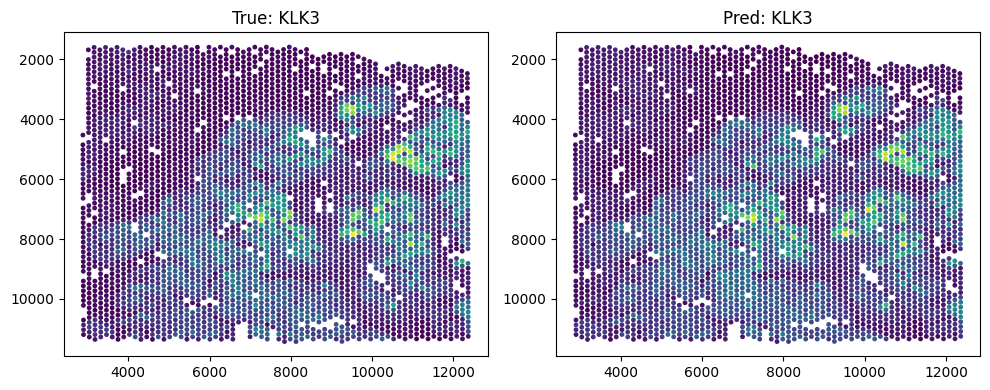

In [9]:
import numpy as np
import matplotlib.pyplot as plt

test_slide_id = test_ids[0]
slide_ds = datasets[test_slide_id]
spot_ids = slide_ds.spot_ids  # 过滤后的 spot 顺序

adata = datas[test_slide_id].adata

# 让 coords 按 spot_ids 对齐
name_to_idx = {sid: i for i, sid in enumerate(adata.obs_names)}
coords = np.array([adata.obsm['spatial'][name_to_idx[sid]] for sid in spot_ids])

# 默认画相关性最高的基因
gene_name = best_gene_name
gene_idx = common_genes.index(gene_name)

# pred_bag/true_bag 是按 test_ids 顺序拼接的，需要切片
offset = 0
for sid in test_ids:
    n = len(datasets[sid])
    if sid == test_slide_id:
        pred_vals = pred_bag[offset:offset+n, gene_idx]
        true_vals = true_bag[offset:offset+n, gene_idx]
        break
    offset += n

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(coords[:, 0], coords[:, 1], c=true_vals, s=6)
plt.gca().invert_yaxis()
plt.title(f'True: {gene_name}')

plt.subplot(1, 2, 2)
plt.scatter(coords[:, 0], coords[:, 1], c=pred_vals, s=6)
plt.gca().invert_yaxis()
plt.title(f'Pred: {gene_name}')

plt.tight_layout()
plt.show()


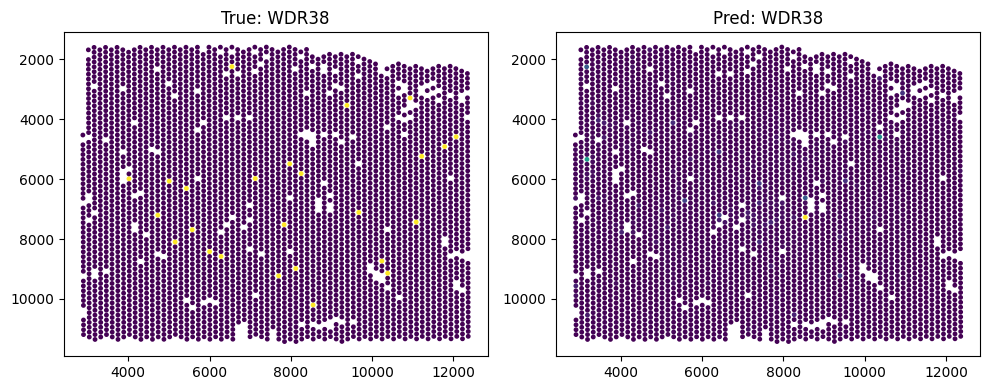

In [11]:
import numpy as np
import matplotlib.pyplot as plt

test_slide_id = test_ids[0]
slide_ds = datasets[test_slide_id]
spot_ids = slide_ds.spot_ids  # 过滤后的 spot 顺序

adata = datas[test_slide_id].adata

# 让 coords 按 spot_ids 对齐
name_to_idx = {sid: i for i, sid in enumerate(adata.obs_names)}
coords = np.array([adata.obsm['spatial'][name_to_idx[sid]] for sid in spot_ids])

# 默认画相关性最高的基因
gene_name = "WDR38"
gene_idx = common_genes.index(gene_name)

# pred_bag/true_bag 是按 test_ids 顺序拼接的，需要切片
offset = 0
for sid in test_ids:
    n = len(datasets[sid])
    if sid == test_slide_id:
        pred_vals = pred_bag[offset:offset+n, gene_idx]
        true_vals = true_bag[offset:offset+n, gene_idx]
        break
    offset += n

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(coords[:, 0], coords[:, 1], c=true_vals, s=6)
plt.gca().invert_yaxis()
plt.title(f'True: {gene_name}')

plt.subplot(1, 2, 2)
plt.scatter(coords[:, 0], coords[:, 1], c=pred_vals, s=6)
plt.gca().invert_yaxis()
plt.title(f'Pred: {gene_name}')

plt.tight_layout()
plt.show()


In [13]:
import numpy as np

# 1) 预测值在基因维度是否真的几乎一样
print("pred 每个基因的标准差均值:", pred_bag.std(axis=0).mean())
print("pred 每个基因的标准差最小:", pred_bag.std(axis=0).min())

# 2) 真实值是否也几乎一样
print("true 每个基因的标准差均值:", true_bag.std(axis=0).mean())
print("true 每个基因的标准差最小:", true_bag.std(axis=0).min())

# 3) gene_ids 是否全一样（核心）
gid = datasets[test_ids[0]].gene_ids
print("gene_ids 唯一值个数:", len(np.unique(gid)))
print("gene_ids 前20个:", gid[:20])
print("gene_ids 范围:", gid.min(), gid.max())


pred 每个基因的标准差均值: 0.6540343
pred 每个基因的标准差最小: 2.6413398e-08
true 每个基因的标准差均值: 1.2009499
true 每个基因的标准差最小: 0.0
gene_ids 唯一值个数: 17512
gene_ids 前20个: [ 1  3  4  6  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25]
gene_ids 范围: 1 27854


In [14]:
model_eval = model.module if is_ddp else model

# 1) 看 gene_emb 是否有变化
gene_emb = model_eval.cellfm.model.gene_emb.detach().cpu().numpy()
print("gene_emb std:", gene_emb.std())
print("gene_emb diff(1,2) mean:", np.abs(gene_emb[1] - gene_emb[2]).mean())

# 2) 看 gene query 是否几乎一样
with torch.no_grad():
    gids = torch.tensor([1, 2, 3, 4], device=device)
    query = torch.sigmoid(model_eval.cellfm.model.cellwise_dec.map(
        model_eval.cellfm.model.gene_emb[gids]
    ))
    print("query std per gene:", query.std(dim=1).cpu().numpy())


gene_emb std: 0.020716818
gene_emb diff(1,2) mean: 0.022076821
query std per gene: [0.00556512 0.00036908 0.00479916 0.00771355]


Loading spatial data from: D:\code\Morpho-VC\data\spatial_data\INT28.h5ad
Coords Range: X[2884.0, 12363.0], Y[1598.0, 11420.0]
Found WSI: D:\code\Morpho-VC\data\hest_data\wsis\INT28.tif
WSI dims (original): 14528 x 13580
Using pixel-space extent (0..W, H..0) for alignment.


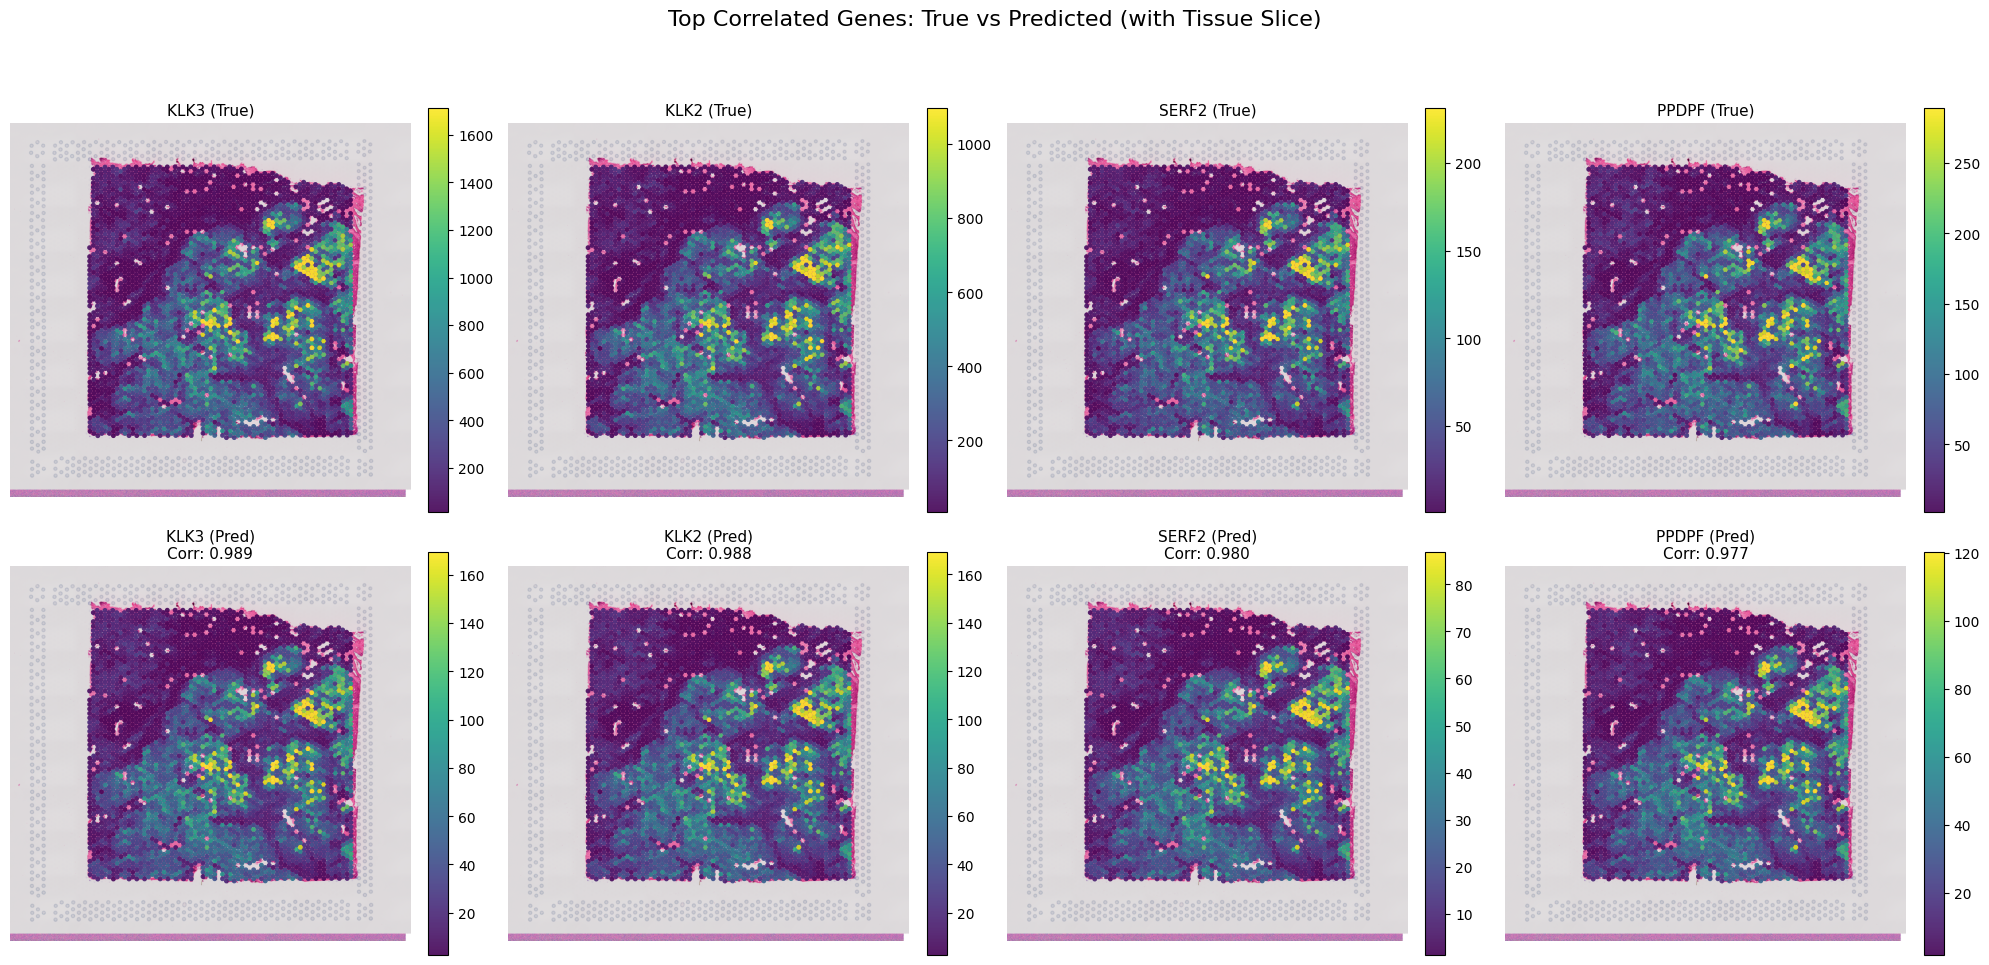

In [15]:
# === Visualizing Spatial Gene-Expression (Top-4) WITH Tissue Slice Background ===
import os
from pathlib import Path

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# Optional: background loading
from PIL import Image


def robust_vmin_vmax(arr, p_low=1, p_high=99):
    """
    Compute (vmin, vmax) from *this panel's* values only (robust percentiles).
    Each panel (each subplot) can have its own scale.
    """
    a = np.asarray(arr, dtype=float)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return 0.0, 1.0

    vmin, vmax = np.percentile(a, [p_low, p_high])
    if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
        vmin, vmax = float(np.min(a)), float(np.max(a))
        if vmin == vmax:
            eps = 1e-6 if vmin == 0 else abs(vmin) * 1e-6
            vmin, vmax = vmin - eps, vmax + eps
    return vmin, vmax


# ----------------------------
# 0) Paths & IDs
# ----------------------------
TEST_ID = "INT28"

if "ROOT" in globals():
    ROOT = Path(ROOT)
else:
    ROOT = Path(os.environ.get("MORPHO_VC_ROOT", "../")).expanduser().resolve()

if "data_dir" in globals():
    data_root = Path(data_dir)
else:
    data_root = ROOT / "data"

if "hest_dir" in globals():
    HEST_DIR = Path(hest_dir)
else:
    HEST_DIR = data_root / "hest_data"

DATA_DIR = data_root / "spatial_data"

h5ad_path = DATA_DIR / f"{TEST_ID}.h5ad"
if not h5ad_path.exists():
    # fallback (keep your style)
    h5ad_path = Path(f"../../data/spatial_data/{TEST_ID}.h5ad").resolve()

print(f"Loading spatial data from: {h5ad_path}")

# ----------------------------
# 1) Load spatial coords (aligned with spot_ids)
# ----------------------------
try:
    if "datas" in globals() and TEST_ID in datas:
        adata = datas[TEST_ID].adata
    else:
        adata = sc.read_h5ad(h5ad_path)

    if "datasets" in globals() and TEST_ID in datasets:
        slide_ds = datasets[TEST_ID]
        spot_ids = slide_ds.spot_ids
        name_to_idx = {sid: i for i, sid in enumerate(adata.obs_names)}
        coords = np.array([adata.obsm["spatial"][name_to_idx[sid]] for sid in spot_ids])
    else:
        coords = adata.obsm["spatial"]
        print("[WARN] datasets not found; using adata.obsm['spatial'] order.")

    x, y = coords[:, 0], coords[:, 1]

    min_x, min_y = coords.min(axis=0)
    max_x, max_y = coords.max(axis=0)
    print(f"Coords Range: X[{min_x:.1f}, {max_x:.1f}], Y[{min_y:.1f}, {max_y:.1f}]")
except Exception as e:
    print(f"[ERROR] Failed to load spatial coords: {e}")
    # last-resort fallback for debugging
    x, y = np.random.rand(pred_bag.shape[0]), np.random.rand(pred_bag.shape[0])
    min_x, min_y, max_x, max_y = x.min(), y.min(), x.max(), y.max()

# ----------------------------
# 1.5) Slice pred/true to TEST_ID (align with coords)
# ----------------------------
pred_bag_slide, true_bag_slide = pred_bag, true_bag
if "datasets" in globals() and "test_ids" in globals():
    offset = 0
    found = False
    for sid in test_ids:
        n = len(datasets[sid])
        if sid == TEST_ID:
            pred_bag_slide = pred_bag[offset:offset + n]
            true_bag_slide = true_bag[offset:offset + n]
            found = True
            break
        offset += n
    if not found:
        raise KeyError(f"{TEST_ID} not found in test_ids: {test_ids}")

if pred_bag_slide.shape[0] != len(x):
    raise ValueError(
        f"Mismatch: coords={len(x)} vs pred_bag={pred_bag_slide.shape[0]} for {TEST_ID}"
    )

# ----------------------------
# 2) Try load WSI background (tissue slice)
# ----------------------------
bg_img = None
bg_extent = None  # (xmin, xmax, ymax, ymin) or (xmin, xmax, ymin, ymax) depending on usage

wsi_files = list((HEST_DIR / "wsis").glob(f"{TEST_ID}.*"))
if len(wsi_files) > 0:
    wsi_path = wsi_files[0]
    print(f"Found WSI: {wsi_path}")

    # Try OpenSlide first (best for .svs/.tiff)
    try:
        import openslide  # noqa: F401

        slide = openslide.OpenSlide(str(wsi_path))
        w0, h0 = slide.dimensions
        print(f"WSI dims (original): {w0} x {h0}")

        # build a thumbnail for plotting speed
        thumb_w = 2000
        scale = thumb_w / w0
        thumb_h = int(h0 * scale)
        bg_img = slide.get_thumbnail((thumb_w, thumb_h))

        # Decide extent strategy:
        # If coords look like they live in pixel space [0..w0, 0..h0], use pixel extent.
        # Else, stretch thumbnail into coords bounding box (still gives a tissue-context background).
        in_pixel_space = (
            (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
            (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
        )

        if in_pixel_space:
            # same convention as your reference code: y-down image coordinates
            bg_extent = (0, w0, h0, 0)
            print("Using pixel-space extent (0..W, H..0) for alignment.")
        else:
            bg_extent = (min_x, max_x, max_y, min_y)
            print("Coords not in pixel space; stretching background to coords bounding box.")

    except Exception as e:
        print(f"OpenSlide failed ({e}), trying PIL...")

        try:
            Image.MAX_IMAGE_PIXELS = None
            img = Image.open(wsi_path)
            w0, h0 = img.size
            print(f"WSI dims (PIL original): {w0} x {h0}")

            img.thumbnail((2000, 2000))
            bg_img = img

            in_pixel_space = (
                (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
                (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
            )
            if in_pixel_space:
                bg_extent = (0, w0, h0, 0)
                print("Using pixel-space extent (0..W, H..0) for alignment.")
            else:
                bg_extent = (min_x, max_x, max_y, min_y)
                print("Coords not in pixel space; stretching background to coords bounding box.")
        except Exception as e2:
            print(f"[WARNING] PIL background load failed: {e2}")
            bg_img, bg_extent = None, None
else:
    print("[INFO] No WSI found under:", (HEST_DIR / "wsis"))

# ----------------------------
# 3) Pick Top-4 genes by correlation (valid: list of (idx, corr))
# ----------------------------
sorted_genes = sorted(valid, key=lambda t: t[1], reverse=True)
top4_genes = sorted_genes[:4]
n_show = len(top4_genes)
if n_show == 0:
    raise ValueError("top4_genes is empty. Check `valid` content.")

# ----------------------------
# 4) Plot (2 rows: True vs Pred) + background slice
#    - NOTE: NO shared scaling: each panel (each subplot) has its own vmin/vmax
# ----------------------------
fig, axes = plt.subplots(2, n_show, figsize=(5 * n_show, 10))
if n_show == 1:
    # keep axes 2D: axes[row, col]
    axes = np.array(axes).reshape(2, 1)

fig.suptitle("Top Correlated Genes: True vs Predicted (with Tissue Slice)", fontsize=16, y=0.98)

for i, (gene_idx, corr) in enumerate(top4_genes):
    gene_name = common_genes[gene_idx]

    gt_expr = true_bag_slide[:, gene_idx]
    pr_expr = pred_bag_slide[:, gene_idx]

    # Panel-wise dynamic range (robust to outliers)
    vmin_gt, vmax_gt = robust_vmin_vmax(gt_expr, p_low=1, p_high=99)
    vmin_pr, vmax_pr = robust_vmin_vmax(pr_expr, p_low=1, p_high=99)

    # --- Row 1: Ground Truth ---
    ax_gt = axes[0, i]
    if bg_img is not None and bg_extent is not None:
        ax_gt.imshow(bg_img, extent=bg_extent)
    sc_gt = ax_gt.scatter(
        x, y, c=gt_expr, cmap="viridis", s=12, alpha=0.9,
        vmin=vmin_gt, vmax=vmax_gt, edgecolors="none"
    )
    ax_gt.set_title(f"{gene_name} (True)", fontsize=11)
    ax_gt.axis("off")
    if bg_img is None:
        ax_gt.invert_yaxis()
    plt.colorbar(sc_gt, ax=ax_gt, fraction=0.046, pad=0.04)

    # --- Row 2: Prediction ---
    ax_pr = axes[1, i]
    if bg_img is not None and bg_extent is not None:
        ax_pr.imshow(bg_img, extent=bg_extent)
    sc_pr = ax_pr.scatter(
        x, y, c=pr_expr, cmap="viridis", s=12, alpha=0.9,
        vmin=vmin_pr, vmax=vmax_pr, edgecolors="none"
    )
    ax_pr.set_title(f"{gene_name} (Pred)\nCorr: {corr:.3f}", fontsize=11)
    ax_pr.axis("off")
    if bg_img is None:
        ax_pr.invert_yaxis()
    plt.colorbar(sc_pr, ax=ax_pr, fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
